In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as web
%matplotlib inline
import datetime
from scipy.stats import norm


In [98]:
def data_frame_asset(ticker,start,end):
    df = web.DataReader(ticker,'yahoo',start,end)
    df['LogReturn'] = np.log(df['Adj Close']/df['Adj Close'].shift(1))
    df = pd.concat([df['Adj Close'],df['LogReturn']],axis=1).dropna()
    df.columns = [ticker,ticker+'LogR']
    return df

In [2]:
def log_return(ticker,start,end):
    df = web.DataReader(ticker,'yahoo',start,end)
    df[ticker] = np.log(df['Adj Close']/df['Adj Close'].shift(1))
    return df[ticker]

In [110]:
def portfolio_assets(tickers,start,end):
    portfolio = pd.concat([data_frame_asset(ticker,start,end)for ticker in tickers],axis=1)
    return portfolio

In [3]:
def portfolio_logr(tickers,start,end):
    portfolio = pd.concat([log_return(ticker,start,end)for ticker in tickers],axis=1)
    return portfolio

In [4]:
start = datetime.datetime(2012,1,1)
end = datetime.datetime(2019,11,16)

In [5]:
tickers = ['NVDA','AMZN','GOOGL','CSCO','BIDU','ADSK','BIIB']

In [6]:
returns = portfolio_logr(tickers,start,end)

In [7]:
returns.head()

,NVDA,AMZN,GOOGL,CSCO,BIDU,ADSK,BIIB
Date,,,,,,,
2012-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-04,0.011332,-0.008526,0.004304,0.019140,-0.018678,-0.019666,0.001936
2012-01-05,0.035286,0.000563,-0.013969,-0.003693,0.010438,0.019991,0.013451
2012-01-06,-0.011624,0.027763,-0.013736,-0.003706,-0.017843,0.004532,0.002080
2012-01-09,0.000000,-0.022428,-0.043324,0.006346,-0.008126,0.003869,-0.005469


In [8]:
weights = np.full((len(tickers),1),1/len(tickers))
weights

array([[0.14285714],
       [0.14285714],
       [0.14285714],
       [0.14285714],
       [0.14285714],
       [0.14285714],
       [0.14285714]])

In [9]:
lookback_days = 520
portfolio_returns = returns[-lookback_days:].dot(weights)

In [11]:
portfolio_returns.tail()

,0
Date,
2019-11-11,-0.008095
2019-11-12,0.006652
2019-11-13,-0.010454
2019-11-14,-0.013021
2019-11-15,0.003585


In [12]:
def value_at_risk_rate(returns,weights,alpha=0.99,lookback_days=520):
    returns = returns.fillna(0.0)
    portfolio_returns = returns.iloc[-lookback_days:].dot(weights)
    return np.percentile(portfolio_returns,100*(1-alpha))

In [13]:
value_at_risk_rate(returns,weights)

-0.046850903760737

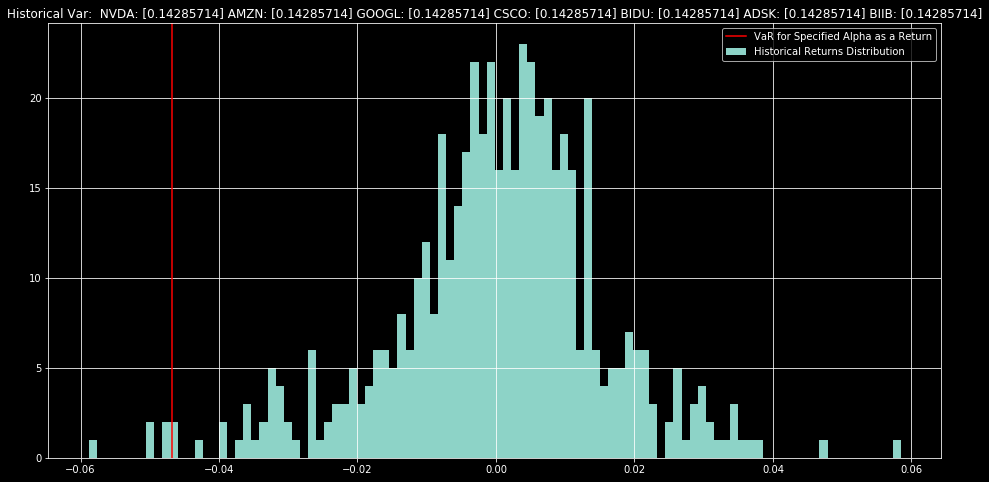

In [14]:
plt.style.use('dark_background')
portfolio_returns.hist(bins=100,figsize=(16,8))
plt.axvline(value_at_risk_rate(returns,weights), c='r')
plt.legend(['VaR for Specified Alpha as a Return', 'Historical Returns Distribution'])
title = 'Historical Var: '
for index,ticker in enumerate(tickers):
    title += ' '+ticker+': '+str(weights[index])
plt.title(title);


In [99]:
from statsmodels.stats.stattools import jarque_bera

In [100]:
jarque_bera(portfolio_returns.dropna())

(array([59.68020346]),
 array([1.09801552e-13]),
 array([-0.4448563]),
 array([4.40102906]))

In [101]:
N = 1000
VaRs = np.zeros((N,1))

In [102]:
for i in range(N):
    VaRs[i] = value_at_risk_rate(returns,weights,lookback_days=i)

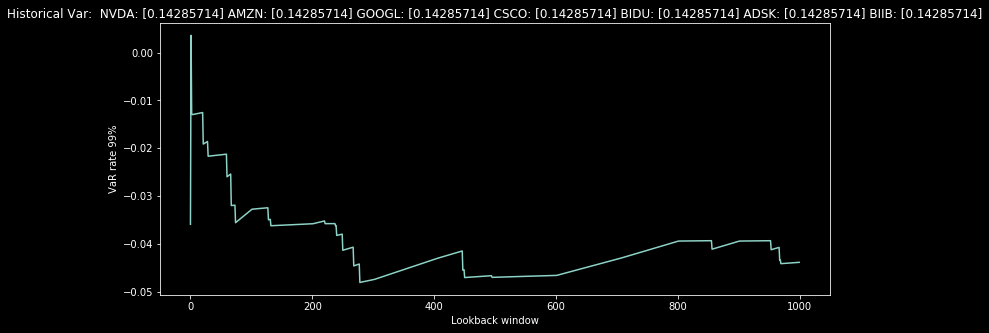

In [103]:
plt.figure(figsize=(12,5))
plt.plot(VaRs)
plt.xlabel('Lookback window')
plt.ylabel('VaR rate 99%')
plt.title(title);

In [104]:
from statsmodels.tsa.stattools import adfuller

In [105]:
data = portfolio_returns.dropna().iloc[:,0].values

In [106]:
results= adfuller(data)


In [108]:
pvalue = results[1]
pvalue

6.895654801419472e-15

In [134]:
calculated_var = value_at_risk_rate(returns,weights)

In [135]:
cvar = np.nanmean(portfolio_returns[portfolio_returns<calculated_var])
cvar

-0.050122311237048606

In [15]:
def cvar(returns,weights,alpha=0.99,lookback_days=500):
    returns = returns.fillna(0.0)
    portfolio_returns = returns[-lookback_days:].dot(weights)
    var = value_at_risk_rate(returns,weights,alpha,lookback_days=lookback_days)
    return np.nanmean(portfolio_returns[portfolio_returns<var])
    

In [33]:
alpha = 0.99
lookback_days = 1000
portfolio_VaR_return = value_at_risk_rate(returns,weights,alpha,lookback_days)
portfolio_CVaR_return = cvar(returns,weights,alpha,lookback_days)

In [34]:
portfolio_VaR_return

-0.04380671754646122

In [35]:
portfolio_CVaR_return

-0.04911166266915765

In [19]:
above_return = portfolio_returns[portfolio_returns > portfolio_VaR_return]
below_return = portfolio_returns[portfolio_returns < portfolio_VaR_return]

In [20]:
below_return.sort_values(0,ascending=False).head(20)

,0
Date,
2019-03-22,-0.030984
2018-10-26,-0.031411
2019-08-23,-0.031560
2019-03-21,-0.031656
2019-01-28,-0.031973
2018-06-25,-0.032039
2018-03-22,-0.032201
2018-10-29,-0.032219
2019-08-14,-0.032719


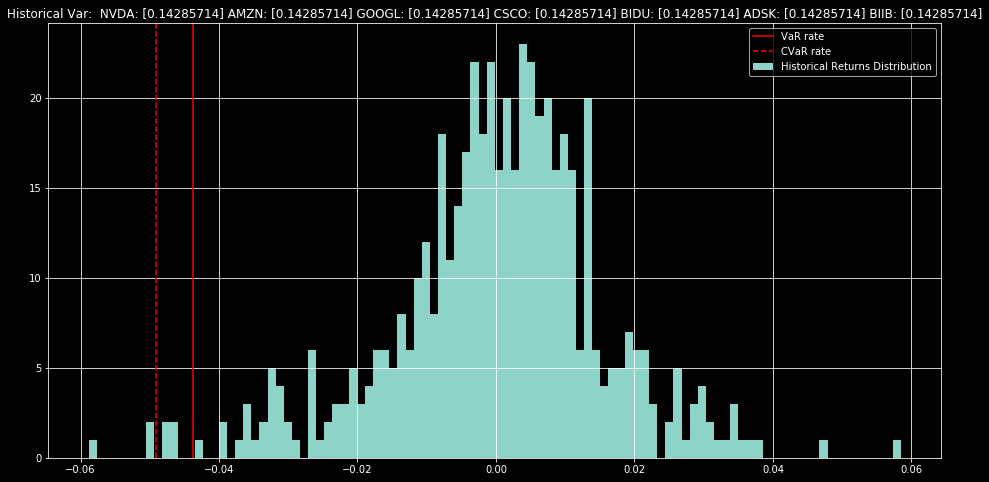

In [36]:
plt.style.use('dark_background')
portfolio_returns.hist(bins=100,figsize=(16,8))
plt.axvline(portfolio_VaR_return, c='r',linestyle='solid')
plt.axvline(portfolio_CVaR_return, c='r',linestyle='dashed')
plt.legend(['VaR rate','CVaR rate','Historical Returns Distribution'])
plt.title(title);